In [2]:
# Convert ticket_end_time to datetime if it's not already
df["ticket_end_time"] = pd.to_datetime(df["ticket_end_time"])

# Set ticket_end_time as the index
df.set_index("ticket_end_time", inplace=True)

# Create time-based features
df["day_of_week"] = df.index.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["month"] = df.index.month
df["day_of_month"] = df.index.day
df["week_of_year"] = df.index.isocalendar().week

# Calculate rolling averages
df["sales_qty_7day_avg"] = df.groupby("article_code")["sales_qty_base_uom"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df["sales_qty_30day_avg"] = df.groupby("article_code")["sales_qty_base_uom"].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Create lag features
df["sales_qty_lag1"] = df.groupby("article_code")["sales_qty_base_uom"].shift(1)
df["sales_qty_lag7"] = df.groupby("article_code")["sales_qty_base_uom"].shift(7)

# Derive features from article data
# Assuming 'article_desc' contains information about brand and category
df["brand"] = df["article_desc"].str.split().str[0]

# Create a price category based on the average price of the article
df["avg_price"] = df.groupby("article_code")["sales_qty_base_uom"].transform("mean")
df["price_category"] = pd.qcut(df["avg_price"], q=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])

Number of zero sales entries: 233


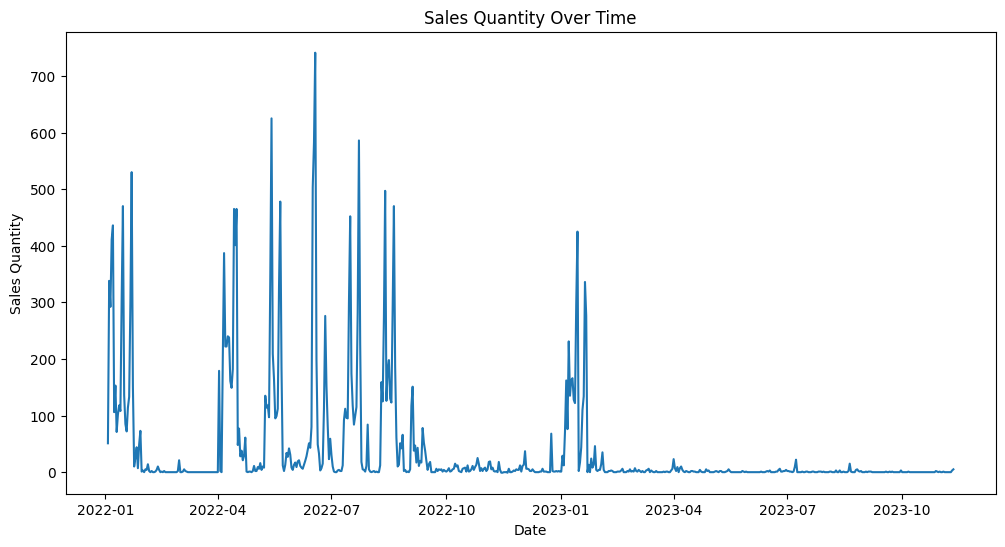

In [24]:
# Check for zero or near-zero sales quantities
zero_sales = product_data[product_data["sales_qty_base_uom"] == 0]
print(f"Number of zero sales entries: {len(zero_sales)}")

# Plot sales data to visualize potential outliers or patterns
plt.figure(figsize=(12, 6))
plt.plot(product_data["sales_qty_base_uom"])
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.title("Sales Quantity Over Time")
plt.show()

# ARIMA #

ADF Statistic: -4.67805613582731
p-value: 9.251374981466752e-05


/var/folders/2n/nk_kz9ln5yn5w2l0d_6mznh40000gn/T/ipykernel_42180/3693300263.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  product_data["sales_qty_base_uom"].fillna(0, inplace=True)


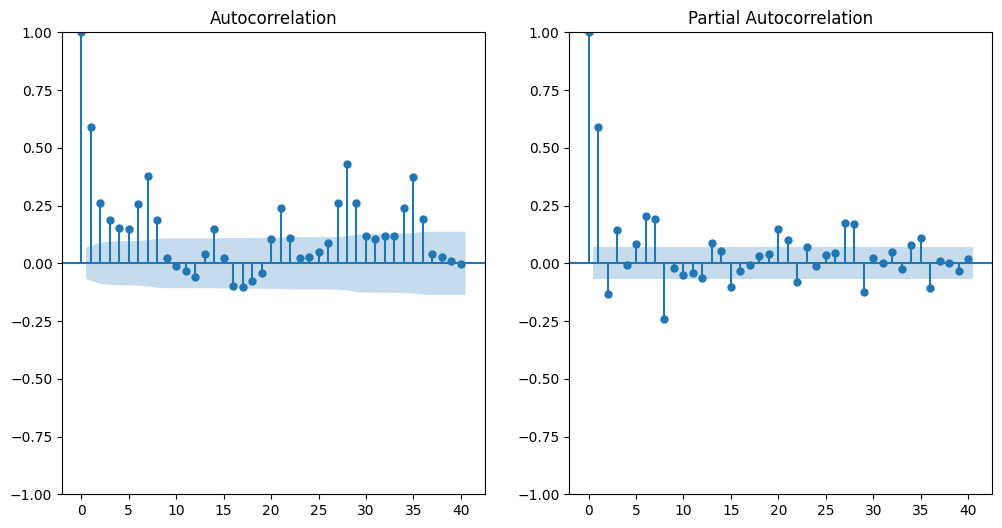

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MAE: 117.20751757920759
Test MSE: 18216.41924189484


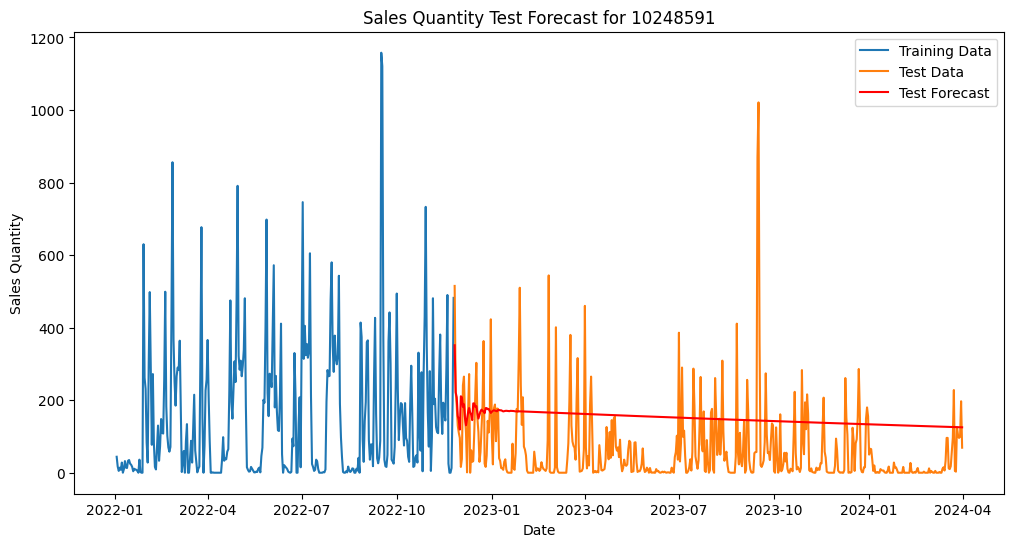

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

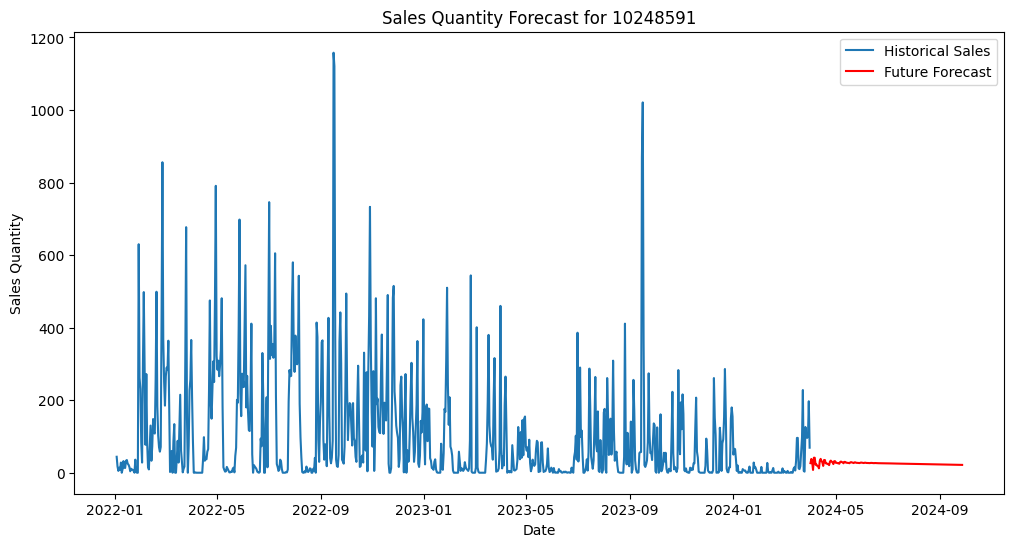

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta

# Load data
df = pd.read_csv("selected_sales.csv")

# Ensure the ticket_end_time is of datetime type
df["ticket_end_time"] = pd.to_datetime(df["ticket_end_time"])
df.set_index("ticket_end_time", inplace=True)

# Define the best articles
best_articles = {10538314, 10248591, 10538316, 10156064, 10725085, 10141470, 10142968, 10125869, 10133205, 10138799, 10130258, 10124088}

# Select the first best article
article_code = 10248591

# Filter the data for the selected article
product_data = df[df["article_code"] == article_code]

# Ensure the data is sorted by date and resample to fill missing dates
product_data = product_data.resample("D").sum()
product_data["sales_qty_base_uom"].fillna(0, inplace=True)

# Check for stationarity
result = adfuller(product_data["sales_qty_base_uom"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(product_data["sales_qty_base_uom"], lags=40, ax=plt.gca())
plt.subplot(122)
plot_pacf(product_data["sales_qty_base_uom"], lags=40, ax=plt.gca())
plt.show()

# Split data into training (70%) and test sets (30%)
n = len(product_data)
train_size = int(n * 0.4)

train = product_data.iloc[:train_size]
test = product_data.iloc[train_size:]

# Manually select the best parameters based on ACF and PACF plots
# Initial guess: ARIMA(5, 1, 0) and SARIMA(1, 1, 1)x(1, 1, 1, 12)
# Adjust these values based on your data analysis
p, d, q = 2, 0, 3
P, D, Q, s = 2, 0, 1, 12

# Fit the ARIMA model on the training data
model = SARIMAX(train["sales_qty_base_uom"], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)

# Forecast on the test set
test_forecast = model_fit.get_forecast(steps=len(test))
test_forecast_df = test_forecast.summary_frame()
test_forecast_df["mean"] = np.maximum(test_forecast_df["mean"], 0)  # To avoid negative predictions

# Calculate evaluation metrics for test set
mae_test = mean_absolute_error(test["sales_qty_base_uom"], test_forecast_df["mean"])
mse_test = mean_squared_error(test["sales_qty_base_uom"], test_forecast_df["mean"])
print(f"Test MAE: {mae_test}")
print(f"Test MSE: {mse_test}")

# Plot the test forecast
plt.figure(figsize=(12, 6))
plt.plot(train["sales_qty_base_uom"], label="Training Data")
plt.plot(test["sales_qty_base_uom"], label="Test Data")
plt.plot(test_forecast_df["mean"], label="Test Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.title(f"Sales Quantity Test Forecast for {article_code}")
plt.legend()
plt.show()

# Forecast the next 180 days using the model fit on the full dataset
full_model = SARIMAX(product_data["sales_qty_base_uom"], order=(p, d, q), seasonal_order=(P, D, Q, s))
full_model_fit = full_model.fit(disp=False)
future_forecast = full_model_fit.get_forecast(steps=180)
future_forecast_df = future_forecast.summary_frame()
future_forecast_df["mean"] = np.maximum(future_forecast_df["mean"], 0)  # To avoid negative predictions
forecast_index = pd.date_range(start=product_data.index[-1] + timedelta(days=1), periods=180, freq="D")
future_forecast_df.index = forecast_index

# Plot the future forecast
plt.figure(figsize=(12, 6))
plt.plot(product_data["sales_qty_base_uom"], label="Historical Sales")
plt.plot(future_forecast_df["mean"], label="Future Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.title(f"Sales Quantity Forecast for {article_code}")
plt.legend()
plt.show()

### Code to evaluate ARIMA models
Steps to Use This Function:
Train your SARIMAX model on the training data.
Call the evaluate_model function with the fitted model and test data.
This function will provide a comprehensive evaluation of your time series model's performance, both through metrics and visual diagnostics. By analyzing these results, you can make informed decisions on whether the model is good enough or needs further tuning.

MAE: 0.9879772330202069
MSE: 5.705093709141099
RMSE: 2.3885337990367854
MAPE: 1008668218872989.5
AIC: 5500.370374792417
BIC: 5537.821240687673


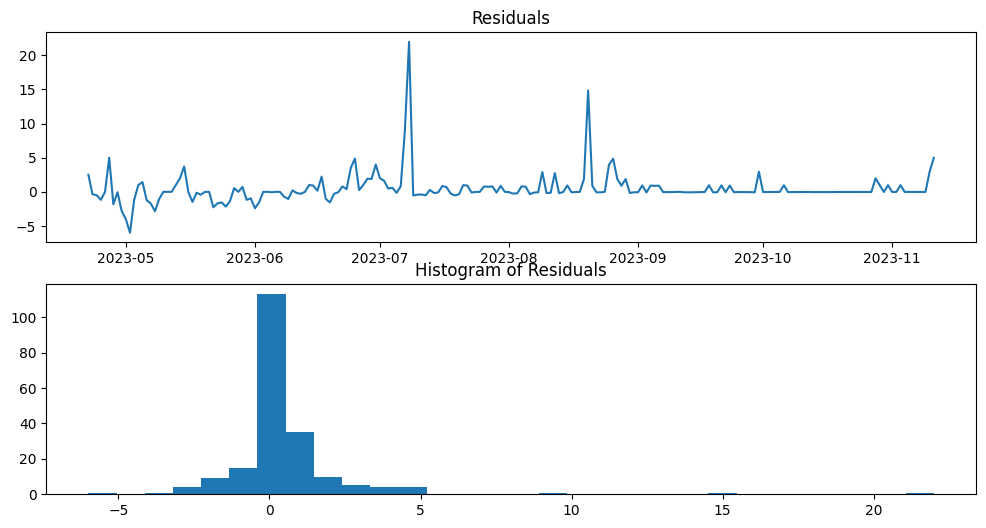

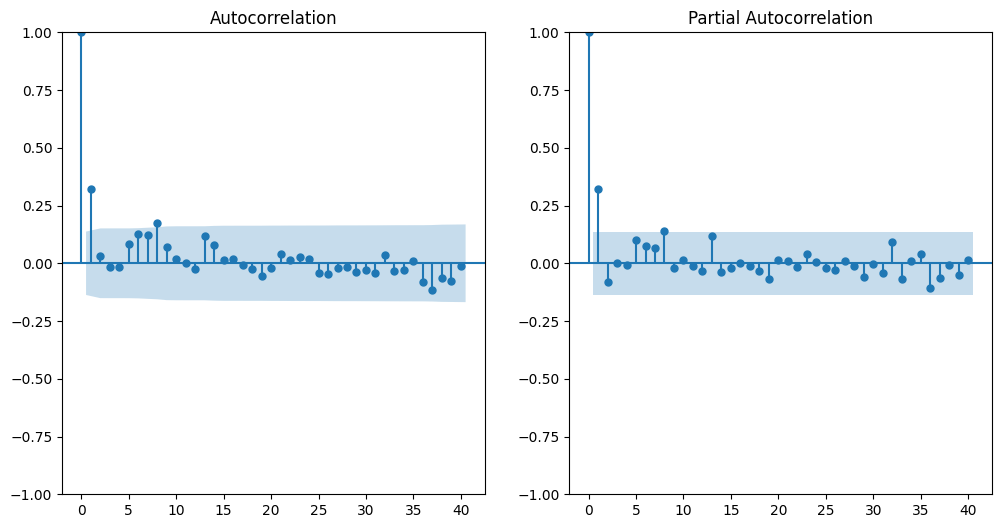

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


def evaluate_model(fitted_model, test_data, steps):
    # Get forecast
    forecast = fitted_model.get_forecast(steps=steps)
    forecast_df = forecast.summary_frame()
    forecast_df["mean"] = np.maximum(forecast_df["mean"], 0)  # To avoid negative predictions

    # Compute metrics
    mae = mean_absolute_error(test_data, forecast_df["mean"])
    mse = mean_squared_error(test_data, forecast_df["mean"])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test_data, forecast_df["mean"])
    aic = fitted_model.aic
    bic = fitted_model.bic

    # Print metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    print(f"AIC: {aic}")
    print(f"BIC: {bic}")

    # Plot residuals
    residuals = test_data - forecast_df["mean"]

    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plt.plot(residuals)
    plt.title("Residuals")

    plt.subplot(212)
    plt.hist(residuals, bins=30)
    plt.title("Histogram of Residuals")
    plt.show()

    # ACF and PACF of residuals
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(residuals, lags=40, ax=plt.gca())

    plt.subplot(122)
    plot_pacf(residuals, lags=40, ax=plt.gca())
    plt.show()


# Example usage
# Assuming you have a fitted SARIMAX model called `model_fit` and test data called `test`
evaluate_model(model_fit, test["sales_qty_base_uom"], len(test))

# Tuning the Arima model #

Ways to train the model:

1. Auto ARIMA (Automated Model Selection)
Auto ARIMA is an automated approach to select the optimal ARIMA parameters by considering various combinations of 
𝑝,
𝑑 and 
𝑞 values. It uses information criteria like AIC and BIC to find the best model.

2. Cross-Validation
Time series cross-validation, also known as rolling forecasting origin, involves splitting the data into training and validation sets multiple times in a way that respects the time order of the data. This helps in understanding how the model performs over different time periods.

3. Bayesian Optimization
Bayesian optimization is a powerful method for hyperparameter tuning. It builds a probabilistic model of the function mapping from hyperparameter values to the objective value and uses this model to select the most promising hyperparameters to evaluate in the true objective function.

4. Genetic Algorithms
Genetic algorithms can be used for hyperparameter tuning by mimicking the process of natural selection. They work by creating a population of models, evaluating their performance, and iteratively selecting the best models to create new offspring models with crossover and mutation operations.

5. Grid Search with Cross-Validation
A more sophisticated approach to grid search involves incorporating cross-validation. This method can be computationally expensive but helps ensure the model's robustness across different subsets of the data.

6. Seasonal Decomposition
Before fitting an ARIMA model, decompose the time series into trend, seasonal, and residual components. This can help you understand the underlying structure of the data and choose the parameters accordingly.

Bayesian Optimization


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



  2%|▏         | 1/50 [00:00<00:33,  1.46trial/s, best loss: 459.2170892444668]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



  4%|▍         | 2/50 [00:04<01:58,  2.46s/trial, best loss: 459.2170892444668]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



  6%|▌         | 3/50 [00:07<02:13,  2.85s/trial, best loss: 459.2170892444668]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



  8%|▊         | 4/50 [00:10<02:04,  2.71s/trial, best loss: 459.2170892444668]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible s

 10%|█         | 5/50 [00:14<02:29,  3.33s/trial, best loss: 459.2170892444668]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 12%|█▏        | 6/50 [00:17<02:22,  3.23s/trial, best loss: 459.2170892444668]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 14%|█▍        | 7/50 [00:19<01:56,  2.71s/trial, best loss: 360.2514837445762]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 16%|█▌        | 8/50 [00:20<01:29,  2.13s/trial, best loss: 25.46597872149447]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible s

 18%|█▊        | 9/50 [00:20<01:07,  1.65s/trial, best loss: 25.46597872149447]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 20%|██        | 10/50 [00:21<00:50,  1.26s/trial, best loss: 25.46597872149447]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 22%|██▏       | 11/50 [00:24<01:12,  1.86s/trial, best loss: 11.085277996459146]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 24%|██▍       | 12/50 [00:24<00:52,  1.39s/trial, best loss: 11.085277996459146]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 26%|██▌       | 13/50 [00:25<00:48,  1.30s/trial, best loss: 11.085277996459146]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 28%|██▊       | 14/50 [00:28<01:06,  1.85s/trial, best loss: 11.085277996459146]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 30%|███       | 15/50 [00:29<00:51,  1.48s/trial, best loss: 11.085277996459146]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autore

 32%|███▏      | 16/50 [00:29<00:39,  1.16s/trial, best loss: 5.635030024901324] 

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



 34%|███▍      | 17/50 [00:30<00:35,  1.08s/trial, best loss: 5.635030024901324]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 36%|███▌      | 18/50 [00:36<01:15,  2.34s/trial, best loss: 5.635030024901324]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 38%|███▊      | 19/50 [00:36<00:56,  1.84s/trial, best loss: 5.635030024901324]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible s

 42%|████▏     | 21/50 [00:37<00:30,  1.06s/trial, best loss: 5.635030024901324]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 44%|████▍     | 22/50 [00:38<00:30,  1.07s/trial, best loss: 5.356402410713231]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 46%|████▌     | 23/50 [00:39<00:28,  1.07s/trial, best loss: 5.356402410713231]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 48%|████▊     | 24/50 [00:40<00:28,  1.08s/trial, best loss: 5.356402410713231]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 50%|█████     | 25/50 [00:41<00:27,  1.11s/trial, best loss: 5.356402410713231]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 52%|█████▏    | 26/50 [00:43<00:26,  1.11s/trial, best loss: 5.356402410713231]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 54%|█████▍    | 27/50 [00:45<00:31,  1.38s/trial, best loss: 5.356402410713231]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 56%|█████▌    | 28/50 [00:46<00:27,  1.26s/trial, best loss: 5.356402410713231]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 58%|█████▊    | 29/50 [00:47<00:25,  1.21s/trial, best loss: 5.356402410713231]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 60%|██████    | 30/50 [00:49<00:28,  1.41s/trial, best loss: 5.253066436520044]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 62%|██████▏   | 31/50 [00:49<00:19,  1.05s/trial, best loss: 5.253066436520044]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 64%|██████▍   | 32/50 [00:51<00:27,  1.54s/trial, best loss: 5.253066436520044]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 66%|██████▌   | 33/50 [00:53<00:27,  1.60s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

 68%|██████▊   | 34/50 [00:55<00:26,  1.68s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible s

 70%|███████   | 35/50 [01:03<00:54,  3.65s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 72%|███████▏  | 36/50 [01:05<00:41,  2.93s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 74%|███████▍  | 37/50 [01:08<00:40,  3.09s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autore

 76%|███████▌  | 38/50 [01:10<00:31,  2.65s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

 78%|███████▊  | 39/50 [01:11<00:25,  2.29s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

 80%|████████  | 40/50 [01:17<00:34,  3.42s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 82%|████████▏ | 41/50 [01:20<00:29,  3.28s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 84%|████████▍ | 42/50 [01:20<00:18,  2.34s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

 86%|████████▌ | 43/50 [01:26<00:24,  3.50s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 88%|████████▊ | 44/50 [01:27<00:16,  2.68s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 90%|█████████ | 45/50 [01:27<00:09,  1.96s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 92%|█████████▏| 46/50 [01:35<00:14,  3.57s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible s

 94%|█████████▍| 47/50 [01:35<00:08,  2.68s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autore

 96%|█████████▌| 48/50 [01:37<00:04,  2.44s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



 98%|█████████▊| 49/50 [01:38<00:01,  1.90s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

100%|██████████| 50/50 [01:41<00:00,  2.02s/trial, best loss: 4.910441469797065]

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Best parameters: {'D': np.float64(0.0), 'P': np.float64(0.0), 'Q': np.float64(2.0), 'd': np.float64(0.0), 'p': np.float64(4.0), 'q': np.float64(5.0)}


/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


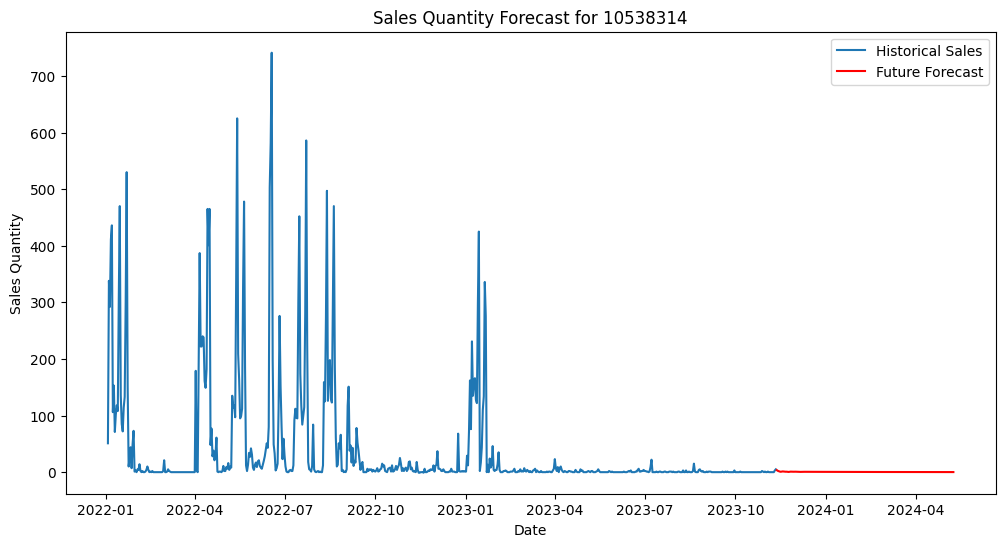

In [14]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np


# Define the objective function for hyperopt
def objective(params):
    order = (int(params["p"]), int(params["d"]), int(params["q"]))
    seasonal_order = (int(params["P"]), int(params["D"]), int(params["Q"]), 12)

    # Fit the model
    model = SARIMAX(train["sales_qty_base_uom"], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Make predictions
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

    # Calculate the mean squared error
    mse = mean_squared_error(test["sales_qty_base_uom"], predictions)

    return {"loss": mse, "status": STATUS_OK}


# Define the search space
space = {"p": hp.quniform("p", 0, 5, 1), "d": hp.quniform("d", 0, 2, 1), "q": hp.quniform("q", 0, 5, 1), "P": hp.quniform("P", 0, 2, 1), "D": hp.quniform("D", 0, 1, 1), "Q": hp.quniform("Q", 0, 2, 1)}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print(f"Best parameters: {best}")

# Fit the final model with the best parameters
final_order = (int(best["p"]), int(best["d"]), int(best["q"]))
final_seasonal_order = (int(best["P"]), int(best["D"]), int(best["Q"]), 12)
final_model = SARIMAX(product_data["sales_qty_base_uom"], order=final_order, seasonal_order=final_seasonal_order)
final_model_fit = final_model.fit(disp=False)

# Forecast the next 180 days
future_forecast = final_model_fit.get_forecast(steps=180)
future_forecast_df = future_forecast.summary_frame()
forecast_index = pd.date_range(start=product_data.index[-1] + timedelta(days=1), periods=180, freq="D")
future_forecast_df.index = forecast_index

# Plot the future forecast
plt.figure(figsize=(12, 6))
plt.plot(product_data["sales_qty_base_uom"], label="Historical Sales")
plt.plot(future_forecast_df["mean"], label="Future Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.title(f"Sales Quantity Forecast for {article_code}")
plt.legend()
plt.show()

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


def sarima_grid_search_cv(data, p_values, d_values, q_values, P_values, D_values, Q_values, s=12, cv=3):
    """
    Perform grid search with cross-validation for SARIMA parameters.

    Parameters:
    - data: Time series data as pandas Series or DataFrame.
    - p_values, d_values, q_values: Lists of integers representing ARIMA model parameters.
    - P_values, D_values, Q_values: Lists of integers representing seasonal ARIMA model parameters.
    - s: Seasonal period (default is 12 for monthly data).
    - cv: Number of cross-validation folds (default is 3).

    Returns:
    - best_params: Dictionary of best parameters found during grid search.
    """
    # Prepare data
    if isinstance(data, pd.DataFrame):
        data = data.squeeze()  # Ensure data is a Series

    # Split data into training and validation sets using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=cv)

    # Initialize variables to store best parameters and minimum MSE
    best_params = None
    min_mse = np.inf

    # Iterate over all combinations of parameters
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            # Initialize lists to store MSE for each fold
                            mse_values = []

                            # Perform cross-validation
                            for train_index, val_index in tscv.split(data):
                                train = data.iloc[train_index]
                                val = data.iloc[val_index]

                                try:
                                    # Fit SARIMA model
                                    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
                                    model_fit = model.fit(disp=False)

                                    # Forecast on validation set
                                    forecast = model_fit.forecast(steps=len(val))

                                    # Calculate MSE
                                    mse = mean_squared_error(val, forecast)
                                    mse_values.append(mse)

                                except:
                                    continue

                            # Calculate average MSE across folds
                            avg_mse = np.mean(mse_values)

                            # Check if current parameters are better
                            if avg_mse < min_mse:
                                min_mse = avg_mse
                                best_params = {"p": p, "d": d, "q": q, "P": P, "D": D, "Q": Q}

    print(f"Best parameters: {best_params}")
    print(f"Minimum MSE: {min_mse}")

    return best_params

In [18]:
# Example usage of the function
data = product_data["sales_qty_base_uom"]  # Assuming this is your time series data

# Define parameter ranges for grid search
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3]
P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1, 2]

# Perform grid search with cross-validation
best_params = sarima_grid_search_cv(data, p_values, d_values, q_values, P_values, D_values, Q_values)

# Now you can use these best parameters to fit your final SARIMA model

/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/dwhoffmann/Desktop/ResurchProject/.venv/l

Best parameters: {'p': 2, 'd': 0, 'q': 3, 'P': 2, 'D': 0, 'Q': 1}
Minimum MSE: 3879.59712984548
